# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.70KFile/s] 


Extracting celeba...


In [16]:
import helper
data_dir = './data'

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

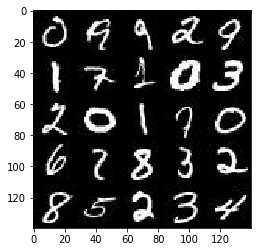

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

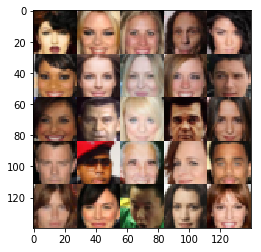

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # ref: from project dlnd_image_classification.ipynb project 2 - 
        # https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
        # ref: https://www.tensorflow.org/tutorials/layers
        
        # Structure we will use: -> CONV -> BatchNorm -> ReLu -> Dropout -> 
        # ref: http://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout-in-tensorflow
        '''
        In the Ioffe and Szegedy 2015(https://arxiv.org/pdf/1502.03167.pdf), the authors state:
           "we would like to ensure that for any parameter values, the network always produces activations with 
           the desired distribution". 
        So the Batch Normalization Layer is actually inserted right after a Conv Layer/Fully Connected Layer, 
        but before feeding into ReLu (or any other kinds of) activation. 
        See this video at around time 53 min for more details (https://www.youtube.com/watch?v=jhUZ800C650&index=5&list=PLLvH2FwAQhnpj1WEB-jHmPuUeQ8mX-XXG).

        Dropout is applied after activation layer, see figure 3b (https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), 
        the dropout factor/probability matrix r(l) for hidden layer l is applied to it on y(l), 
        where y(l) is the result after applying activation function f.
        '''

        
        # params
        alpha=0.2 #for leaky ReLU adjustment
        standard_dev=0.02
            
        """Model function for CNN."""
        # Input Layer
        # input_layer = tf.reshape(features, [-1, 28, 28, 1])

        # LAYER 1 - 28x28
        # Convolutional Layer #1
        conv1 = tf.layers.conv2d(
        inputs=images,            #tensor input
        filters=64,               #number of convolutions 
        kernel_size=[5, 5],       #width and height of the 2D convolution window 
        strides=2,                #strides of the convolution along the height and width
        padding="same",
        activation=None,          #linear activation
        kernel_initializer = tf.random_normal_initializer(stddev=standard_dev))
        
        # Leaky ReLU 1 - Now apply activation - negative input (x) values is alpha*x, 
        # and the output for positive x is x
        leaky_ReLU1 = tf.maximum(alpha * conv1, conv1)
        
        # LAYER 2 - 14x14
        
        # Convolutional Layer #2
        conv2 = tf.layers.conv2d(
        inputs=leaky_ReLU1,       
        filters=128,              
        kernel_size=[5, 5],       
        strides=2,                
        padding="same",
        activation=None,          
        kernel_initializer = tf.random_normal_initializer(stddev=standard_dev))
        # Batch Normalization - 
        # technique to provide any layer in a Neural Network with inputs that are zero mean/unit variance
        # set `updates_collections=None` to force updates in place, however it comes with speed penalty
        
        # ref: http://stackoverflow.com/questions/40879967/how-to-use-batch-normalization-correctly-in-tensorflow
        
        # The main tips with using the official implementation of batch normalization in 
        # tf.contrib.layers.batch_norm are: 
        #    (1) set is_training=True for training time and is_training=False for validation and testing time; 
        is_training=True
        #    (2) set updates_collections=None to make sure that moving_variance and moving_mean are updated in place; 
        updates_collections=None #ops.GraphKeys.UPDATE_OPS
        #    (3) set decay to be a smaller value (decay=0.9 or decay=0.99) than default value (default is 0.999) if your dataset is small or your total training updates/steps are not that large.
        decay=0.9

        batch_norm2 = tf.contrib.layers.batch_norm(conv2, decay=decay, is_training=is_training,
                                              updates_collections=updates_collections)
                    
        
        # Leaky ReLU 2
        leaky_ReLU2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # LAYER 3 - 7x7
        
        # Convolutional Layer #3        
        conv3 = tf.layers.conv2d(
        inputs=leaky_ReLU2,       
        filters=256,              
        kernel_size=[5, 5],       
        strides=2,                
        padding="same",
        activation=None,          
        kernel_initializer = tf.random_normal_initializer(stddev=standard_dev))
        
        #end shape is 4*4 with 256 filters
        
        batch_norm3 = tf.contrib.layers.batch_norm(conv3, decay=decay, is_training=is_training,
                                              updates_collections=updates_collections)
                    
        
        # Leaky ReLU 3
        leaky_ReLU3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        # LAYER 4
        # Dense Layer
        leaky_ReLU3_flat = tf.reshape(leaky_ReLU3, [-1, 4 * 4 * 256])  # <-- check shape not ()

        #??? start
        #dense
        dense = tf.layers.dense(inputs=leaky_ReLU3_flat, units=1024, activation=tf.nn.relu)
        #dropout
        leaky_ReLU3_flat = tf.layers.dropout(inputs=dense, rate=0.4, training=True)
        #??? end
        
        logits = tf.layers.dense(leaky_ReLU3_flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def deconvolutions( inputs, is_train, filters, kernal_size, strides, padding='same', 
                   decay=0.999, updates_collections=None, alpha=0.1, standard_dev=0.02):
    '''
    Create a deconvolutional layer
    :inputs: Input tensor.
    :param is_train: Boolean if generator is being used for training
    :param filters: Integer, the dimensionality of the output space (i.e. the number of filters in the convolution).
    :param kernel_size: A tuple or list of 2 positive integers specifying the spatial dimensions of of the filters. Can be a single integer to specify the same value for all spatial dimensions.
    :param strides: A tuple or list of 2 positive integers specifying the strides of the convolution. Can be a single integer to specify the same value for all spatial dimensions.
    :param padding: one of "valid" or "same" (case-insensitive).
    :param decay: set decay to be a smaller value (decay=0.9 or decay=0.99) than default value (default is 0.999) if your dataset is small or your total training updates/steps are not that large.
    :param updates_collections:
    :param alpha: used by leaky ReLU to reduce impack of negatives but still keep in scope
    :param standard_dev: for initalising the deconvolutional weights
    :return: The tensor output of this layer
    '''
    #shape
    # conv2d_transpose is used as the gradient of conv2d, The formulas for the shape of the output of conv2d are:
    #    (1) output = (input - filter + stride) // stride  # VALID
    #    (1) output = (input + stride - 1) // stride  # SAME
    
    
    # Batch Normalization
    # Accelerating Deep Network Training by Reducing Internal Covariate Shift
    # Can be used as a normalizer function for conv2d and fully_connected
    # Batch Normalization layer from http://arxiv.org/abs/1502.03167.
    # ref: https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/layers/batch_norm
    #batch_norm = tf.contrib.layers.batch_norm(dconv, decay=decay, is_training=is_train, center=True, scale=True,
    #                                          updates_collections=None)
    
    dconv = tf.layers.conv2d_transpose(inputs, filters, kernal_size, strides=strides, padding=padding,
                                        kernel_initializer=tf.random_normal_initializer(stddev=standard_dev))
    
    batch_norm = tf.layers.batch_normalization(dconv, training=is_train)
    
    leaky_ReLU = tf.maximum(alpha * batch_norm, batch_norm)
    
    return leaky_ReLU


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Deconvolve with conv2d_transpose to build the image from the "snow crash" input....!
    
    # ref: https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose
    
    alpha=0.1 #for leaky ReLU adjustment
    standard_dev=0.02
    
    #rescale the images to be between -1 and 1 as using tanh
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Fully Connected LAYER 1
        fully_connected = tf.layers.dense(z, 7*7*512)
        
        # start to Deconvolution (Transposed convolution layer )
        # shape z for the deconvolution
        fully_connected_reshape = tf.reshape(fully_connected, [-1, 7, 7, 512])
        
        batch_norm1 = tf.layers.batch_normalization(fully_connected_reshape, training=is_train)
        
        #leaky ReLU 1 
        layer1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        #print("1shape - {}".format(layer1.shape))
        
        #hidden layers
        layer2 = deconvolutions( layer1, is_train=is_train, filters=256, kernal_size=5, strides=2, padding='same')
        #print("2shape - {}".format(layer2.shape))
        
        layer3 = deconvolutions( layer2, is_train=is_train, filters=128, kernal_size=5, strides=2, padding='same')
        #print("3shape - {}".format(layer3.shape))
        
        # Output layer 
        # dimensions need to be 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=standard_dev))
        #print("4shape - {}".format(logits.shape))
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    #ref: Intro_to_GANs_Solution.ipynb
    
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    # Calculate losses    
    # label smoothing - To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9
    smooth = 0.1

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #ref: Intro_to_GANs_Solution.ipynb
    
    # Get the trainable_variables, split into Generator and Discriminator parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    
    # use the collection UPDATE_OPS - ref: https://www.tensorflow.org/api_docs/python/tf/GraphKeys
    # explanation here - http://ruishu.io/2016/12/27/batchnorm/
    
    # Note: When is_training is True the moving_mean and moving_variance need to be updated, 
    # by default the update_ops are placed in tf.GraphKeys.UPDATE_OPS so they need to be added as a 
    # dependency to the train_op
    
    # Hey graph, update the moving averages before you finish the training step!
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars) 

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    # params
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    n_images = 25 #images to display

    # model inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)

    # model the loss for discriminator and generator and set the losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    # optimiser - using learning rate passed in
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # counter to show output
            diaplay_output = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # scale the batch X 2 to make it between -1, 1 (By default they are between -0.5 to 0.5. )
                batch_images = batch_images*2.0 
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Display training output every 10 batches and image every 100
                diaplay_output += 1
                if (diaplay_output % 10 == 0):
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                    
                #print the generator output every 100 batches
                if (diaplay_output % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 2.0646
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 4.6915
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 5.0666
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 4.2044
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 2.1902
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.4373
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.8894


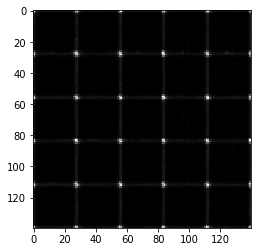

Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.0417
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.4331
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 2.1880
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.1811


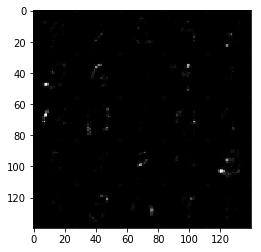

Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.9725
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.5962
Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.8344
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.6976
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.8880
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.1865


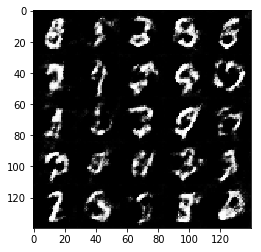

Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 2.7499
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 2.6687
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 2.0070
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.2292
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 1.0713
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 2.4939
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 2.0462


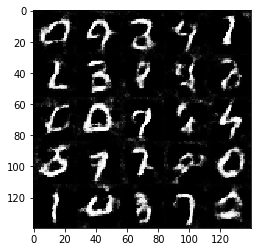

Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.6676
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.4288
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.2454
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 2.1739
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 1.7019
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.5764
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.2187
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.5926
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 2.4290
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.2715
Epoch 2/2.

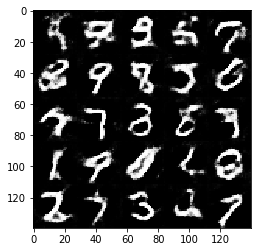

Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.4611
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.4165
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.6595
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 2.3297
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.6699
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.9224
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.7149


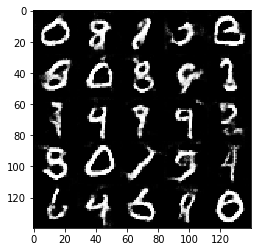

Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.4970
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.5295
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 2.1434
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.6250
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.5654


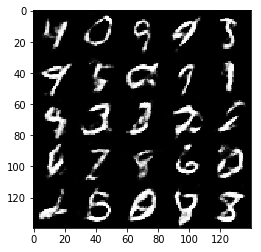

Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.5779
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.6214
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.5881
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.1751
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.9289
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.5063
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.2786
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 2.4579


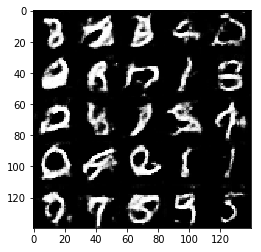

Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 2.2123
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 0.8681
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.0333


In [77]:
batch_size = 128 # recommended size
z_dim = 128
learning_rate = 0.0002 # recommended size 
beta1 = 0.5


"""

DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2



mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 2.0150
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.9542
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 2.0615
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 2.0650
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 3.5037
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.6288


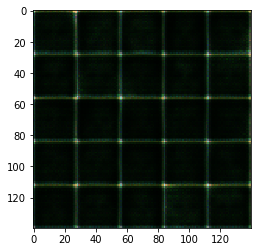

Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 2.3380
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 2.7420
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 2.0764
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.6026
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 5.0797
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.7224
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 3.1593
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 2.3452
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.0514


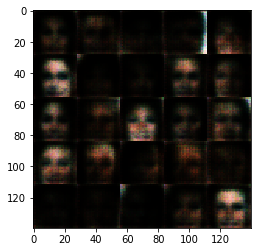

Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.1830
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.9398
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 8.7779
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 2.3010
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 6.6831
Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.7919... Generator Loss: 5.7689


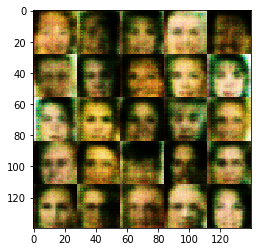

Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 3.9490
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 1.9359
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 4.9013
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.6509


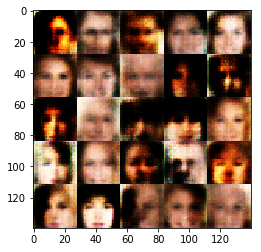

Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 2.4838
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 2.4821
Epoch 1/1... Discriminator Loss: 2.5257... Generator Loss: 5.0961
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 2.0114... Generator Loss: 0.2963


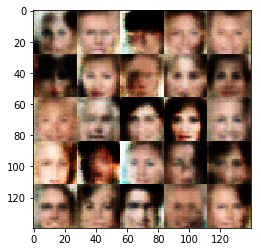

Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 3.3685
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 4.4890
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 5.8020
Epoch 1/1... Discriminator Loss: 3.7017... Generator Loss: 5.4406
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6134


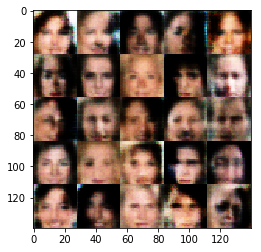

Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.7797
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 2.6629
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 4.1220
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.1762


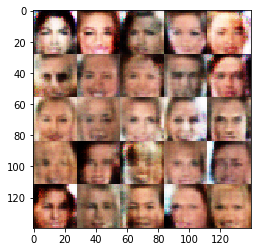

Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.8445
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 3.1642
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 2.9393


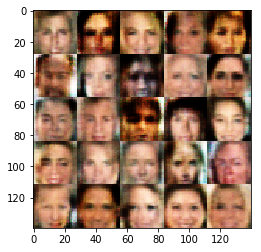

Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 3.3043
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 2.1338
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 2.0707
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.9480
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 3.2042


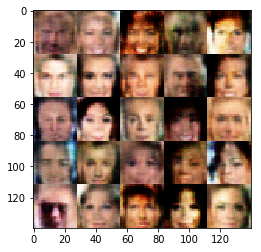

Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.8970
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 3.1892
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 3.5960
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7006


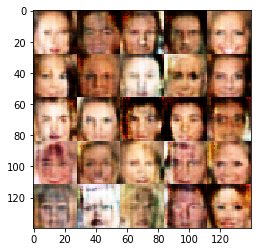

Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.7081
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.8664
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 2.9178
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 2.5778


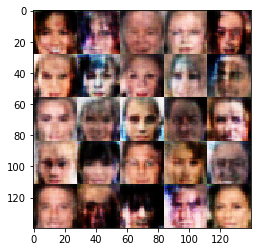

Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.5115
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.8836
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.4076


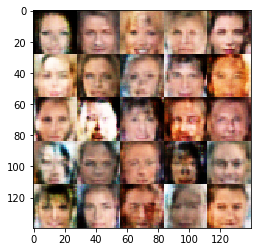

Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.8444
Epoch 1/1... Discriminator Loss: 1.8925... Generator Loss: 3.2469
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.4702
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.8613
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.5159
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 2.0381


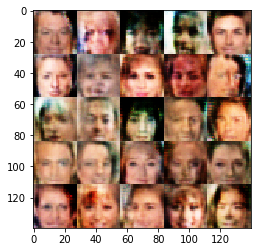

Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 5.0368
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.5105
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 2.0256
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 2.0973


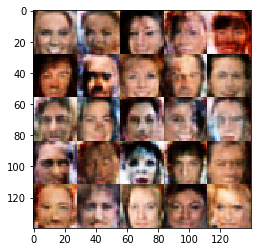

Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 3.9628
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.4227
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 2.2607
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1839


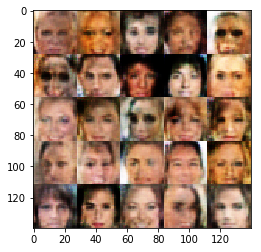

Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 3.2957
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.5574
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9184


In [79]:
batch_size = 128 # recommended size
z_dim = 128
learning_rate = 0.0002 # recommended size 
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.